<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/SAM/Fine_tune_SAM_(segment_anything)_on_a_custom_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook: fine-tune SAM (segment anything) on a custom dataset

In this notebook, we'll reproduce the [MedSAM](https://github.com/bowang-lab/MedSAM) project, which fine-tunes [SAM](https://huggingface.co/docs/transformers/main/en/model_doc/sam) on a dataset of medical images. For demo purposes, we'll use a toy dataset, but this can easily be scaled up.

Resources used to create this notebook (thanks 🙏):
* [Encode blog post](https://encord.com/blog/learn-how-to-fine-tune-the-segment-anything-model-sam/)
* [MedSAM repository](https://github.com/bowang-lab/MedSAM).

## Set-up environment

We first install 🤗 Transformers and 🤗 Datasets.

In [75]:
# Upload the fine-tuned model to the Hugging Face Hub

from huggingface_hub import notebook_login
from transformers import SamModel

notebook_login()  # Authentifiez-vous sur le Hub

In [1]:
from datasets import load_dataset
from PIL import Image
import random
import numpy as np

# Charger le dataset
dataset = load_dataset("Jour/equirectangular_street_view_masking", split="train")

size = (256, 256)

# Transformation sur un batch
def crop_random_half_batch(examples):
    images = examples["image"]
    masks = examples["mask"]
    new_images = []
    new_masks = []

    for img, mask in zip(images, masks):
        # S'assurer que ce sont bien des images PIL
        img = img if isinstance(img, Image.Image) else Image.fromarray(img)
        mask = mask if isinstance(mask, Image.Image) else Image.fromarray(mask)

        w, h = img.size
        assert w == 2 * h, f"Expected 2:1 aspect ratio, got {w}x{h}"

        if random.random() < 0.5:
            box = (0, 0, h, h)  # moitié gauche
        else:
            box = (w - h, 0, w, h)  # moitié droite

        # resize to 256x256
        img = img.crop(box).resize(size, Image.LANCZOS)
        mask = mask.crop(box).resize(size, Image.LANCZOS)
        
        new_images.append(img)
        new_masks.append(mask)

    return {"image": new_images, "mask": new_masks}

# Appliquer la transformation
dataset = dataset.with_transform(crop_random_half_batch)


/home/jourdelune/Bureau/dev/3dgs-street-view/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset

Dataset({
    features: ['image', 'mask'],
    num_rows: 207
})

We can visualize an example:

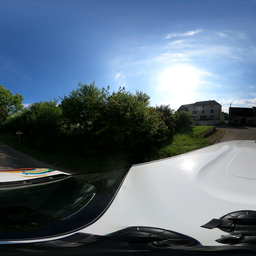

In [3]:
example = dataset[0]
image = example["image"]
image

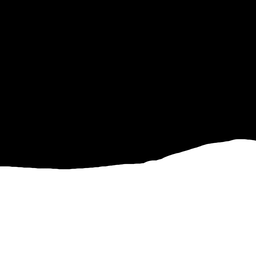

In [4]:
mask = example["mask"]
mask


(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

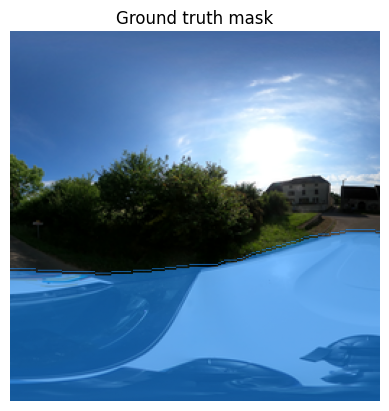

In [5]:
import matplotlib.pyplot as plt
import numpy as np 


def convert_mask_to_binary(mask):
    """Convert a mask to binary format (0 or 1)."""
    return np.array(mask) > 0  # Assuming mask values are > 0 for foreground

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

fig, axes = plt.subplots()

axes.imshow(np.array(image))
ground_truth_seg = convert_mask_to_binary(np.array(example["mask"]))
show_mask(ground_truth_seg, axes)
axes.title.set_text(f"Ground truth mask")
axes.axis("off")

## Create PyTorch dataset

Below we define a regular PyTorch dataset, which gives us examples of the data prepared in the format for the model. Each example consists of:

* pixel values (which is the image prepared for the model)
* a prompt in the form of a bounding box
* a ground truth segmentation mask.

The function below defines how to get a bounding box prompt based on the ground truth segmentation. This was taken from [here](https://github.com/bowang-lab/MedSAM/blob/66cf4799a9ab9a8e08428a5087e73fc21b2b61cd/train.py#L29).

Note that SAM is always trained using certain "prompts", which you could be bounding boxes, points, text, or rudimentary masks. The model is then trained to output the appropriate mask given the image + prompt.

In [6]:
def get_bounding_box(ground_truth_map):
    return [0, 0, ground_truth_map.shape[1], ground_truth_map.shape[0]]

In [7]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = convert_mask_to_binary(np.array(item["mask"]))

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [8]:
from transformers import SamProcessor

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [9]:
train_dataset = SAMDataset(dataset=dataset, processor=processor)

In [10]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


## Create PyTorch DataLoader

Next we define a PyTorch Dataloader, which allows us to get batches from the dataset.



In [11]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)

In [12]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [13]:
batch["ground_truth_mask"].shape

torch.Size([2, 256, 256])

## Load the model

In [14]:
from transformers import SamModel 

model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

## Train the model

In [15]:
from torch.optim import Adam
import monai

# Note: Hyperparameter tuning could improve performance here
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)

seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [16]:
import torch.nn.functional as F

def resize_mask(mask, size):
    """
    mask : tensor shape (batch_size, 1, H, W)
    size : tuple (new_height, new_width)
    """
    return F.interpolate(mask, size=size, mode="bilinear", align_corners=False)

In [77]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

num_epochs = 100

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

  7%|▋         | 7/104 [00:05<01:16,  1.26it/s]/home/jourdelune/Bureau/dev/3dgs-street-view/.venv/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (96438272 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
100%|██████████| 104/104 [01:27<00:00,  1.19it/s]


EPOCH: 0
Mean loss: 0.06078290495161827


100%|██████████| 104/104 [01:27<00:00,  1.18it/s]


EPOCH: 1
Mean loss: 0.0678929052530573


100%|██████████| 104/104 [01:26<00:00,  1.20it/s]


EPOCH: 2
Mean loss: 0.0639852961847702


100%|██████████| 104/104 [01:27<00:00,  1.19it/s]


EPOCH: 3
Mean loss: 0.06024998335096125


100%|██████████| 104/104 [01:30<00:00,  1.15it/s]


EPOCH: 4
Mean loss: 0.05465593796151762


100%|██████████| 104/104 [01:26<00:00,  1.21it/s]


EPOCH: 5
Mean loss: 0.053891177683208995


100%|██████████| 104/104 [01:26<00:00,  1.21it/s]


EPOCH: 6
Mean loss: 0.05759901438768093


100%|██████████| 104/104 [01:30<00:00,  1.15it/s]


EPOCH: 7
Mean loss: 0.05433209713261861


100%|██████████| 104/104 [01:31<00:00,  1.14it/s]


EPOCH: 8
Mean loss: 0.0522070993633511


100%|██████████| 104/104 [01:26<00:00,  1.20it/s]


EPOCH: 9
Mean loss: 0.061087380145461515


100%|██████████| 104/104 [01:30<00:00,  1.15it/s]


EPOCH: 10
Mean loss: 0.054970010344942026


100%|██████████| 104/104 [01:31<00:00,  1.14it/s]


EPOCH: 11
Mean loss: 0.06013077699865859


100%|██████████| 104/104 [01:32<00:00,  1.13it/s]


EPOCH: 12
Mean loss: 0.05594667366061073


 50%|█████     | 52/104 [00:43<00:43,  1.19it/s]


KeyboardInterrupt: 

## Inference

Important note here: as we used the Dice loss with `sigmoid=True`, we need to make sure to appropriately apply a sigmoid activation function to the predicted masks. Hence we won't use the processor's `post_process_masks` method here.

In [78]:
import numpy as np
from PIL import Image

# Charger le dataset
dataset_test = load_dataset("Jour/equirectangular_street_view_masking", split="test")

size = (256, 256)

# Transformation sur un batch
def crop_random_half_batch(examples):
    images = examples["image"]
    masks = examples["mask"]
    new_images = []
    new_masks = []

    for img, mask in zip(images, masks):
        # S'assurer que ce sont bien des images PIL
        img = img if isinstance(img, Image.Image) else Image.fromarray(img)
        mask = mask if isinstance(mask, Image.Image) else Image.fromarray(mask)

        w, h = img.size
        assert w == 2 * h, f"Expected 2:1 aspect ratio, got {w}x{h}"

        if random.random() < 0.5:
            box = (0, 0, h, h)  # moitié gauche
        else:
            box = (w - h, 0, w, h)  # moitié droite

        # resize to 256x256
        img = img.crop(box).resize(size, Image.LANCZOS)
        mask = mask.crop(box).resize(size, Image.LANCZOS)
        
        new_images.append(img)
        new_masks.append(mask)

    return {"image": new_images, "mask": new_masks}

# Appliquer la transformation
dataset_test = dataset_test.with_transform(crop_random_half_batch)

Generating test split: 100%|██████████| 24/24 [00:00<00:00, 189.91 examples/s]


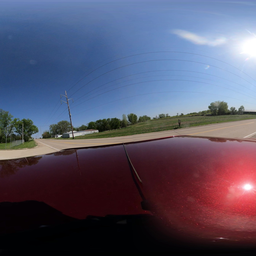

In [86]:
# let's take a random training example
idx = 8

# load image
out = dataset_test[idx]
out["image"]

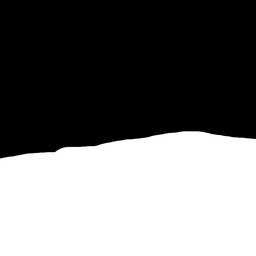

In [87]:
out["mask"]

In [88]:
# get box prompt based on ground truth segmentation map
ground_truth_mask = convert_mask_to_binary(np.array(out["mask"]))
prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(out["image"], input_boxes=[[prompt]], return_tensors="pt").to(device)
for k,v in inputs.items():
  print(k,v.shape)

pixel_values torch.Size([1, 3, 1024, 1024])
original_sizes torch.Size([1, 2])
reshaped_input_sizes torch.Size([1, 2])
input_boxes torch.Size([1, 1, 4])


In [89]:
model.eval()

# forward pass
with torch.no_grad():
  outputs = model(**inputs, multimask_output=False)

In [90]:
# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

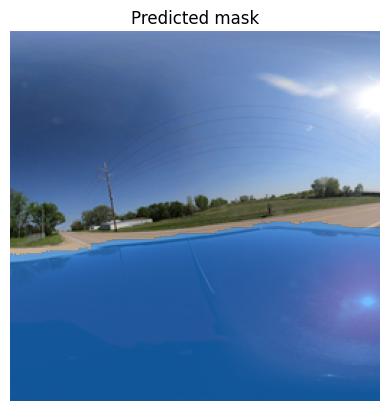

In [91]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

fig, axes = plt.subplots()

axes.imshow(np.array(out["image"]))
show_mask(medsam_seg, axes)
axes.title.set_text(f"Predicted mask")
axes.axis("off")

Compare this to the ground truth segmentation:

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

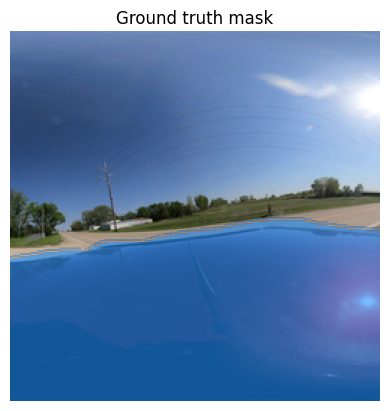

In [92]:
fig, axes = plt.subplots()

axes.imshow(np.array(out["image"]))
show_mask(ground_truth_mask, axes)
axes.title.set_text(f"Ground truth mask")
axes.axis("off")

In [93]:
# Remplacez par votre nom d'utilisateur et le nom du repo souhaité
repo_name = "Jour/sam-vit-base-equirectangular-finetuned"

model.push_to_hub(repo_name)
processor.push_to_hub(repo_name)

model.safetensors: 100%|██████████| 375M/375M [00:16<00:00, 23.1MB/s] 
No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/Jour/sam-vit-base-equirectangular-finetuned/commit/48d0d4014d9d3691208219c42873741ef679f2f5', commit_message='Upload processor', commit_description='', oid='48d0d4014d9d3691208219c42873741ef679f2f5', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Jour/sam-vit-base-equirectangular-finetuned', endpoint='https://huggingface.co', repo_type='model', repo_id='Jour/sam-vit-base-equirectangular-finetuned'), pr_revision=None, pr_num=None)